<h1> Libraries Import </h1>

In [1]:
import datetime as dt
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV
import random
import tensorflow as tf

# Data Download
This project works on S&P 500. The last 1-year data is used and acquired via the yfinance library.

In [2]:
# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
# Download the past 1-year data

stocks = ['^SPX']

end = dt.datetime.today()
start = end - dt.timedelta(360)

data = {}

for ticker in stocks: 
    data[ticker] = yf.download(ticker,start,end)

print(data[ticker])

[*********************100%%**********************]  1 of 1 completed

                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2023-07-24  4543.390137  4563.410156  4541.290039  4554.640137  4554.640137   
2023-07-25  4555.189941  4580.620117  4552.419922  4567.459961  4567.459961   
2023-07-26  4558.959961  4582.470215  4547.580078  4566.750000  4566.750000   
2023-07-27  4598.259766  4607.069824  4528.560059  4537.410156  4537.410156   
2023-07-28  4565.750000  4590.160156  4564.009766  4582.229980  4582.229980   
...                 ...          ...          ...          ...          ...   
2024-07-10  5591.259766  5635.390137  5586.439941  5633.910156  5633.910156   
2024-07-11  5635.209961  5642.450195  5576.529785  5584.540039  5584.540039   
2024-07-12  5590.759766  5655.560059  5590.439941  5615.350098  5615.350098   
2024-07-15  5638.160156  5666.939941  5614.750000  5631.220215  5631.220215   
2024-07-16  5644.089844  5665.020020  5639.020020  5

<h1> Data Engineering </h1>

<p> Data are prepared for the model input by following a few crucial steps: </p>
<ul>
        <li> Handling Missing Information: missing data for weekends and holidays are filled in using forward fill to ensure continuity in the dataset. </li>
        <li> Using Only Close Price as Feature: For the analysis, only the close price of the S&P 500 index (^SPX) is used.</li>
        <li> Data Scaling: The close price data is scaled using MinMaxScaler to normalize the data. Scaling the data is important because it ensures that all features have the same scale, which can significantly improve the performance and convergence speed of machine learning models. It also helps in preventing any one feature from dominating the learning process due to its larger range of </li>
</ul>

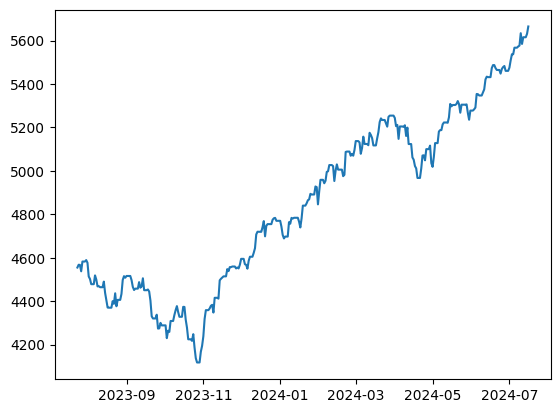

In [4]:
# Add weekends and holidays using forward fill
for stock in stocks:
    data[stock] = data[stock].asfreq("D")
    data[stock].fillna(method='ffill', inplace=True)
    
# Use only close price as feature
stock_data = data['^SPX']
stock_data_close = data['^SPX']['Close']

plt.plot(stock_data_close)

In [5]:
# Data Scaling
scaler = MinMaxScaler()
stock_data_close = scaler.fit_transform(np.array(stock_data_close).reshape(-1,1))


<h1> Modeling and Testing </h1>

<p> A function <code>creating_rolling_window_dataset</code> is defined to create input sequences and their corresponding output values. This rolling window approach allows the model to learn from a sequence of past values to predict the next value. </p>

In [6]:
def create_rolling_window_dataset(dataset, timestep):
    """
    Function that transforms a single time series into a set of input sequences for training and corresponding output. Each input sequence contains a specified number of past observations, and the output is the observation
        immediately following each input sequence.

    Input:
        dataset (np.array): input time series data
        timestep (int): number of time steps to include in each input sequence
    
    Output:
        data(X) (np.array): set of input sequences
        data(Y) (np.array): set of corresponding output
    """
    dataX, dataY = [], []
    for i in range(len(dataset) - timestep):
        dataX.append(dataset[i: (i+timestep)])
        dataY.append(dataset[(i+timestep)])
    return np.array(dataX), np.array(dataY)

In [7]:
## Train test split
train_size = .7
train_data, test_data = stock_data_close[: int(len(stock_data_close)*train_size)], stock_data_close[int(len(stock_data_close)*train_size) :]

timestep = 12
X_train, Y_train = create_rolling_window_dataset(train_data, timestep)
X_test, Y_test = create_rolling_window_dataset(test_data, timestep)


In [8]:
def lstm_model(units=50, optimizer='adam'):
    model = Sequential()
    model.add(LSTM(units,return_sequences = False,input_shape = (X_train.shape[1],1)))
    model.add(Dense(1))
    model.compile(loss = 'mean_squared_error',optimizer = optimizer)
    return model

In [9]:
def calculate_mape(Y_true, Y_pred):
    return np.mean(np.abs((Y_true-Y_pred)/Y_true)) * 100

In [10]:
def plot_true_predict(stock_data, stock_data_close, timestep, scaler, train_predict, test_predict):
    plt.plot(stock_data.index, scaler.inverse_transform(stock_data_close), label='True Data')

    train_predict_plot = np.empty_like(stock_data_close)
    train_predict_plot[:] = np.nan
    train_predict_plot[timestep:int(len(stock_data_close)*0.7)] = train_predict

    test_predict_plot = np.empty_like(stock_data_close)
    test_predict_plot[:] = np.nan
    test_predict_plot[int(len(stock_data_close)*0.7) + timestep:] = test_predict

    plt.plot(stock_data.index, train_predict_plot, label='Train Predict', color='orange')
    plt.plot(stock_data.index, test_predict_plot, label='Test Predict', color='green')

    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

In [11]:
# Initialize model for hyperparameter tuning
model2 = KerasRegressor(model=lstm_model, verbose=0, units=32, random_state=42)

# Define the parameter grid
param_grid = {
    'units': [32, 64, 128],
    'optimizer': ['adam', 'rmsprop'],
    'batch_size': [32, 64, 128],
    'epochs': [50, 100]
}

# Perform grid search
grid = GridSearchCV(estimator=model2, param_grid=param_grid, cv=3, n_jobs=-1)
grid_result = grid.fit(X_train, Y_train)
print(f'Best {grid_result.best_score_, grid_result.best_params_}')

Best (0.6604104987963266, {'batch_size': 32, 'epochs': 100, 'optimizer': 'adam', 'units': 128})


In [12]:
# Predict on Test set with best parameters
model = lstm_model(units=128, optimizer='adam') # Best (0.6604104987963266, {'batch_size': 32, 'epochs': 100, 'optimizer': 'adam', 'units': 128})
model.fit(X_train,Y_train,validation_data = (X_test,Y_test), epochs=100, batch_size=32) 

train_predict = model.predict(X_train)
train_predict = scaler.inverse_transform(train_predict)
    
test_predict = model.predict(X_test)
test_predict = scaler.inverse_transform(test_predict)

# Print result
print(math.sqrt(mean_squared_error(scaler.inverse_transform(Y_train),train_predict))) # 43.00773311279729
print(math.sqrt(mean_squared_error(scaler.inverse_transform(Y_test),test_predict))) # 56.67818086816067

print(calculate_mape(scaler.inverse_transform(Y_train), train_predict)) # 0.7181894938137735
print(calculate_mape(scaler.inverse_transform(Y_test), test_predict)) # 0.9137832030647802

Epoch 1/100
8/8 [==============================] - 1s 43ms/step - loss: 0.0820 - val_loss: 0.0037
Epoch 2/100
8/8 [==============================] - 0s 6ms/step - loss: 0.0116 - val_loss: 0.0075
Epoch 3/100
8/8 [==============================] - 0s 6ms/step - loss: 0.0071 - val_loss: 0.0273
Epoch 4/100
8/8 [==============================] - 0s 6ms/step - loss: 0.0037 - val_loss: 0.0024
Epoch 5/100
8/8 [==============================] - 0s 6ms/step - loss: 0.0030 - val_loss: 0.0025
Epoch 6/100
8/8 [==============================] - 0s 6ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 7/100
8/8 [==============================] - 0s 6ms/step - loss: 0.0016 - val_loss: 0.0029
Epoch 8/100
8/8 [==============================] - 0s 6ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 9/100
8/8 [==============================] - 0s 6ms/step - loss: 0.0014 - val_loss: 0.0027
Epoch 10/100
8/8 [==============================] - 0s 6ms/step - loss: 0.0013 - val_loss: 0.0016
Epoch 11/100
8/8 [==========

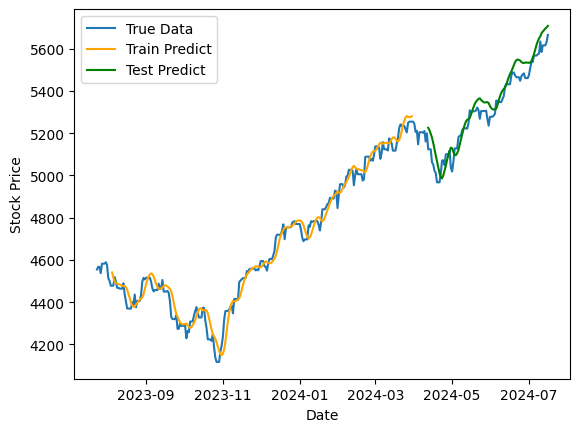

In [13]:
# Plot the true stock data and predicted
plot_true_predict(stock_data, stock_data_close, timestep, scaler, train_predict, test_predict)

<h1> Predict into the Future <h1> 

In [14]:
def predict_future(model, recent_data, timestep, scaler):
    predictions = []
    input_data = recent_data[-timestep:].reshape(1,timestep,1)
    
    for _ in range(timestep):
        next_pred = model.predict(input_data) 
        predictions.append(next_pred)
        input_data = np.append(input_data[:,1:,:], next_pred.reshape((1,1,1)), axis=1)
        
    return scaler.inverse_transform(np.array(predictions).reshape(-1,1))

In [15]:
future_predictions = predict_future(model, np.array(stock_data_close), timestep, scaler)

futures_dates = pd.date_range(start=stock_data.index[-1] + dt.timedelta(1), periods=timestep, freq='B')
future_predictions = pd.DataFrame(future_predictions, index=futures_dates, columns=['Predicted Close'])

1/1 [==============================] - 0s 9ms/step


In [16]:
print(future_predictions)

            Predicted Close
2024-07-17      5719.482422
2024-07-18      5743.081543
2024-07-19      5773.455566
2024-07-22      5808.938965
2024-07-23      5848.511719
2024-07-24      5891.436035
2024-07-25      5938.548828
2024-07-26      5987.070312
2024-07-29      6039.214355
2024-07-30      6094.273926
2024-07-31      6152.502441
2024-08-01      6214.550293
